# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [6]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [7]:
results=(rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])*dataframe)
drift=results.copy()

for col in drift.columns:
    drift[col]=drift[col]/results.sum(axis=1)
performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)
last_weights=rolling_optimization.loc[dates_end[-3]]
weights_bench=pd.DataFrame(drift.iloc[-1])
weights_bench.columns=['Weights Model']

# Importing Data

In [9]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [10]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [12]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [13]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [14]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [15]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [16]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [17]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)


In [18]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_157536\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [19]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


USDUSDT not retrieved


In [20]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [21]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],weights_bench,realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2111.4899,2040.5890,1.0000,1.0000,-146.9409,76.04,-70.9009,-3.3579
TRXUSDT,0.2647,872.3899,1037.7808,0.5086,0.5551,-12.2962,165.39,153.0938,7.2505
BTCUSDT,68795.5284,565.5529,906.1931,0.4441,0.4449,13.0697,340.64,353.7097,16.7517
OMUSDT,1.1299,526.3213,96.2820,0.0472,0.0000,0.0000,-430.04,-430.0400,-20.3667
ETHUSDT,3654.5327,0.1328,0.1554,0.0001,0.0000,55.9949,0.02,56.0149,2.6529
LTCUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
XLMUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
BCHUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
LINKUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000
ADAUSDT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0000,0.0000


In [22]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.round(2)

,Portfolio,Model,Positions,Model Positions,Spread
XRPUSDT,0.00,0.00,0.00,0.00,0.00
TRXUSDT,0.51,0.56,1037.78,1132.79,95.01
LPTUSDT,0.00,0.00,0.00,0.00,0.00
BTCUSDT,0.44,0.44,906.19,907.80,1.61
NOTUSDT,0.00,0.00,0.00,0.00,0.00
BBUSDT,0.00,0.00,0.00,0.00,0.00
NEARUSDT,0.00,0.00,0.00,0.00,0.00
EURUSDT,0.00,0.00,0.00,0.00,0.00
RNDRUSDT,0.00,0.00,0.00,0.00,0.00
ENSUSDT,0.00,0.00,0.00,0.00,0.00


In [23]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [24]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [25]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [26]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [27]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [28]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [30]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 515e50345ea491d22ac98ed41f9b748b7db768fd)
✅ File pushed/updated successfully!


In [31]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [32]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [33]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [34]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 0b51ca3522d057002a18010f6b258c2d0fba37b1)
✅ File pushed/updated successfully!


In [35]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [36]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [37]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [38]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [39]:
# pnl_history['Total']

In [40]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [41]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [42]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [43]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [44]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-01   -529.919593
2025-09-02   -508.112304
2025-09-03   -496.598689
2025-09-04   -527.004696
2025-09-05    133.939240
Name: Total, Length: 348, dtype: float64

<Axes: >

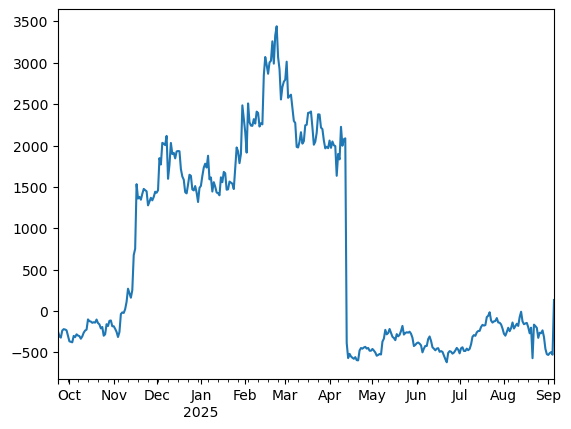

In [45]:
pnl_history['Total'].plot()

In [46]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-06     36.413389
2025-08-07     68.439267
2025-08-08    -72.407830
2025-08-09     28.619211
2025-08-10     28.580156
2025-08-11    -26.126058
2025-08-12    106.411481
2025-08-13     65.040275
2025-08-14   -116.944819
2025-08-15    -33.788702
2025-08-16      9.416085
2025-08-17      6.186404
2025-08-18    -51.411836
2025-08-19    -74.026161
2025-08-20     67.755802
2025-08-21   -368.329352
2025-08-22    405.182289
2025-08-23    -17.678735
2025-08-24    -20.768624
2025-08-25   -121.271345
2025-08-26     62.086247
2025-08-27     -5.984666
2025-08-28     34.510654
2025-08-29    -80.680751
2025-08-30   -142.309648
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05    660.943936
Name: Total, dtype: float64

In [47]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.1395851994525, -950.5160328166937)

In [48]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [49]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [50]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [51]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [53]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [54]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

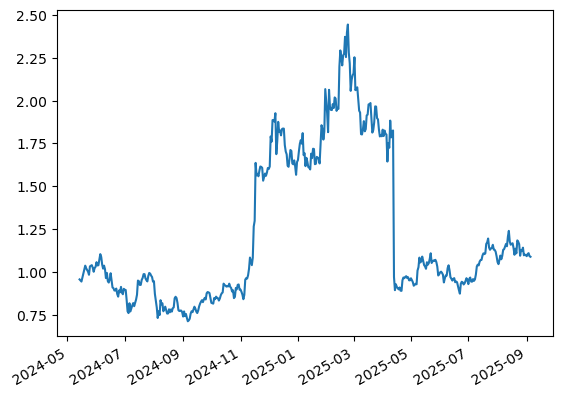

In [55]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

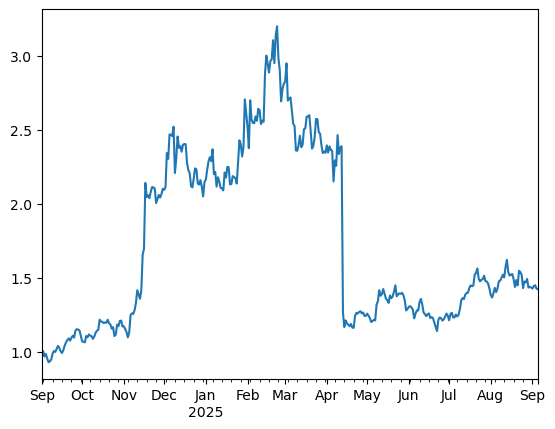

In [56]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [58]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [338]:
days=30
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [340]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [344]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
ZECUSDT,0.4433
BNBUSDT,0.4242
AAVEUSDT,0.1325
LINKUSDT,0.0000
ARBUSDT,0.0000
FLOKIUSDT,0.0000
BONKUSDT,0.0000
CRVUSDT,0.0000
ENSUSDT,0.0000
CFXUSDT,0.0000


In [345]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.628784
ZECUSDT,0.371216


In [347]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

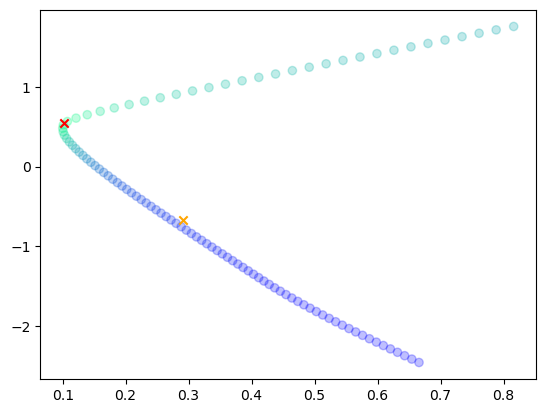

In [348]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [351]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [352]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1037.7808,0.5086,0.0000,0.5086
BTCUSDT,906.1931,0.4441,0.0000,0.4441
OMUSDT,96.2820,0.0472,0.0000,0.0472
ETHUSDT,0.1554,0.0001,0.0000,0.0001
SOLUSDT,0.0887,0.0000,0.0000,0.0000
BNBUSDT,0.0558,0.0000,0.0000,0.0000
USDCUSDT,0.0333,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.9949,-0.9949
ZECUSDT,0.0000,0.0000,0.0051,-0.0051


### Current results

In [354]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [355]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,1.0


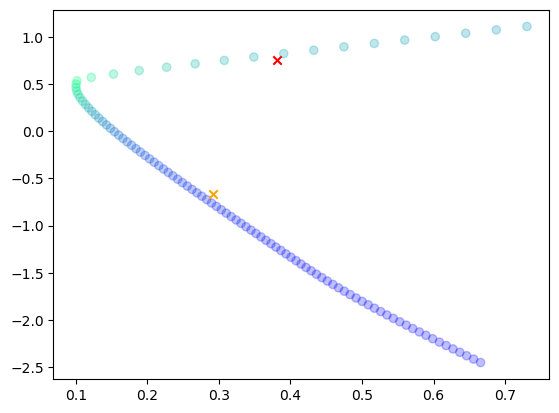

In [356]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [357]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1037.7808,0.5086,0.0,0.5086
BTCUSDT,906.1931,0.4441,0.0,0.4441
OMUSDT,96.2820,0.0472,0.0,0.0472
ETHUSDT,0.1554,0.0001,0.0,0.0001
SOLUSDT,0.0887,0.0000,0.0,0.0000
BNBUSDT,0.0558,0.0000,1.0,-1.0000
USDCUSDT,0.0333,0.0000,0.0,0.0000
PEPEUSDT,0.0000,0.0000,0.0,0.0000


# Risk Reward Analysis

In [77]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [78]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

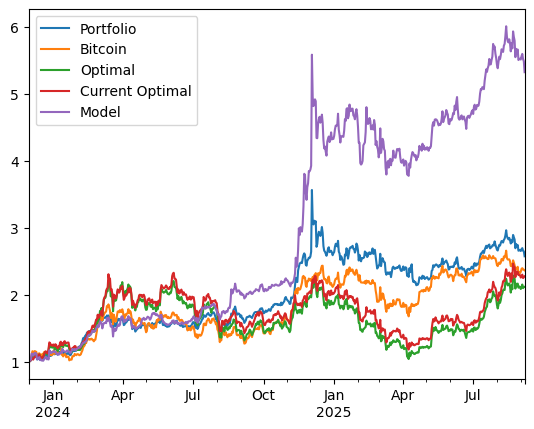

In [79]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [80]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

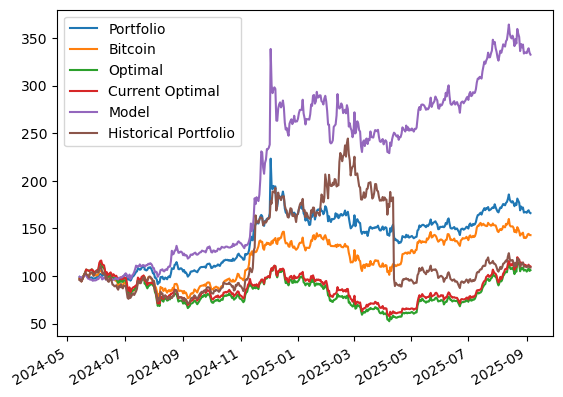

In [81]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

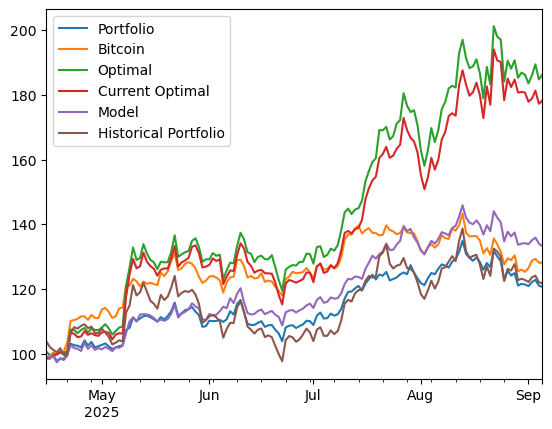

In [82]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

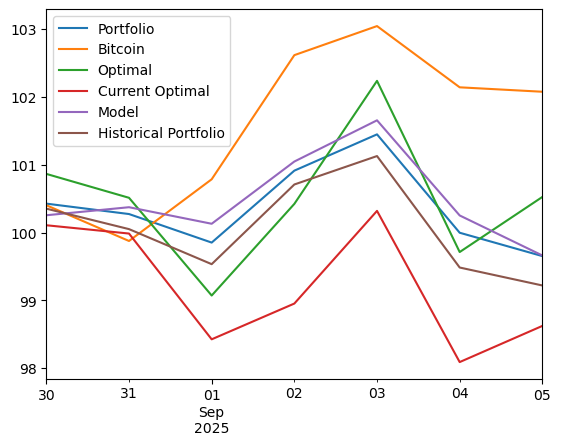

In [83]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [84]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-08-30,100.427928,100.404183,100.866376,100.108933,100.256523,100.353789
2025-08-31,100.274349,99.876884,100.513917,99.986659,100.375067,100.051951
2025-09-01,99.853386,100.787165,99.072514,98.426551,100.131023,99.535062
2025-09-02,100.914415,102.618109,100.424379,98.954171,101.048872,100.710311
2025-09-03,101.449663,103.046817,102.238789,100.320771,101.656807,101.129679
2025-09-04,99.998558,102.143595,99.713864,98.090850,100.253504,99.485482
2025-09-05,99.654069,102.078191,100.526441,98.624389,99.663253,99.220782


## Volatilities

In [86]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.424186
 dtype: float64,
 0.4241858231478574)

In [87]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.252884
 dtype: float64,
 0.25288449790710993)

In [88]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.404185
Bitcoin            0.404414
Optimal            0.469390
Current Optimal    0.448935
Model              0.466671
dtype: float64

In [89]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20227226539782353

In [90]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

0.1320680768177101

<Axes: >

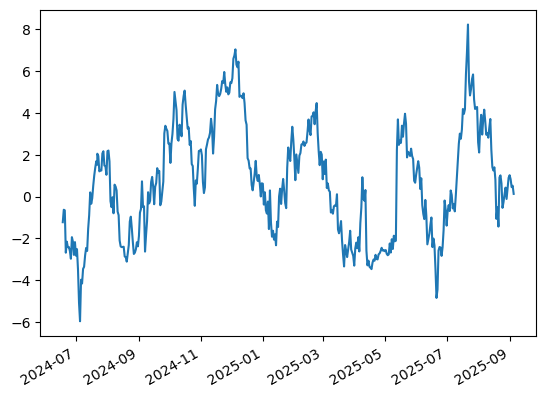

In [91]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [92]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.627424444169338

## Risk Contribution

In [94]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
WBETHUSDT,25.6288,0.5504,0.3286,0.2218
BNBUSDT,12.8570,0.2937,0.1016,0.1921
BCHUSDT,5.1394,0.1239,0.0302,0.0937
CFXUSDT,0.8962,0.0320,0.0040,0.0280
Portfolio,44.5214,1.0000,0.4643,0.5357


In [95]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
ETHUSDT,25.181732,0.576335,0.355059,0.221276
BNBUSDT,17.494935,0.423665,0.202389,0.221276
Portfolio,42.676667,1.000000,0.557447,0.442553


In [96]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,5.189679,0.507554,0.331152,0.176402
BTCUSDT,1.345010,0.383682,0.198526,0.185155
OMUSDT,-2.053493,0.108764,0.038866,0.069898
Portfolio,4.481197,1.000000,0.568545,0.431455


# Value At Risk

## Historical

### Optimal Weights

In [100]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.048965248466136514, -0.0660493865821342)

### Current Weights

In [102]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03482251539519476, -0.04558671623471079)

In [103]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [104]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.023534
BTCUSDT     -0.006549
OMUSDT      -0.003408
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.033492
Name: 2025-06-11 00:00:00, dtype: float64

In [105]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.026061
BTCUSDT     -0.009929
OMUSDT      -0.003550
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.039539
dtype: float64

## Parametric

### Optimal Weights

In [108]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.06216279560815402, -0.0769926887816352)

### Current Weights

In [110]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03705924738175619, -0.04590030213780977)

## Multivariate

### Optimal Weights

In [113]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.057930655435062824, -0.0667057267046639)

### Current Weights

In [115]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03580165936179136, -0.04150575143376964)

In [116]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.018366
BTCUSDT     -0.014464
OMUSDT      -0.003547
Portfolio   -0.036378
dtype: float64

In [117]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.017797
BTCUSDT     -0.015123
OMUSDT      -0.003912
Portfolio   -0.036832
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [121]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05785585931230191, -0.0667511982995364)

### Current Weights

In [123]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.036250751448217135, -0.04191244191489552)

In [124]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [127]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05740098422813172, -0.067267397688687)

### Current Weights

In [129]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.03755180455224952, -0.0427881401957736)

In [130]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [133]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09706438024595408, -0.11973024425660413)

### Current Weights

In [135]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0668939461020499, -0.08229538256027281)

In [136]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [139]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [140]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06262216423158623, -0.07117219479127684)

### Current Weights

In [142]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.037236643818421226, -0.04275114571662268)

In [143]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [144]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.023294,-0.017967,-0.013486,-0.018366,-0.019114
BTCUSDT,-0.016160,-0.013908,-0.010620,-0.014464,-0.014295
OMUSDT,-0.002572,-0.004440,-0.002366,-0.003547,-0.004509
Portfolio,-0.042027,-0.036315,-0.026472,-0.036378,-0.037918


In [145]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.026025,-0.018218,-0.013960,-0.017797,-0.019621
BTCUSDT,-0.013850,-0.013976,-0.010716,-0.015123,-0.013803
OMUSDT,-0.002711,-0.004595,-0.002061,-0.003912,-0.005003
Portfolio,-0.042587,-0.036789,-0.026737,-0.036832,-0.038427


## VaR Violation

In [147]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.039862,-0.062749,-0.058193,-0.023966
2024-01-15,-0.039862,-0.063893,-0.057876,0.033213
2024-01-16,-0.039862,-0.062980,-0.055504,0.010501
2024-01-17,-0.039862,-0.064013,-0.059225,-0.020463
2024-01-18,-0.039862,-0.064230,-0.059534,-0.007270
...,...,...,...,...
2025-09-02,-0.058877,-0.077967,-0.073802,0.013645
2025-09-03,-0.058877,-0.076467,-0.071761,0.018067
2025-09-04,-0.058877,-0.076406,-0.072572,-0.024696
2025-09-05,-0.058877,-0.076022,-0.073279,0.008149


In [148]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047592,-0.048432,-0.046157,-0.036683
2023-12-16,-0.047592,-0.048481,-0.045052,0.010565
2023-12-17,-0.047592,-0.049098,-0.048525,-0.013644
2023-12-18,-0.047592,-0.049210,-0.047694,0.007530
2023-12-19,-0.047592,-0.046636,-0.046887,-0.004343
...,...,...,...,...
2025-09-02,-0.043531,-0.049497,-0.053775,0.010626
2025-09-03,-0.043531,-0.048687,-0.049533,0.005304
2025-09-04,-0.043531,-0.047785,-0.051817,-0.014304
2025-09-05,-0.043531,-0.047615,-0.052414,-0.003445


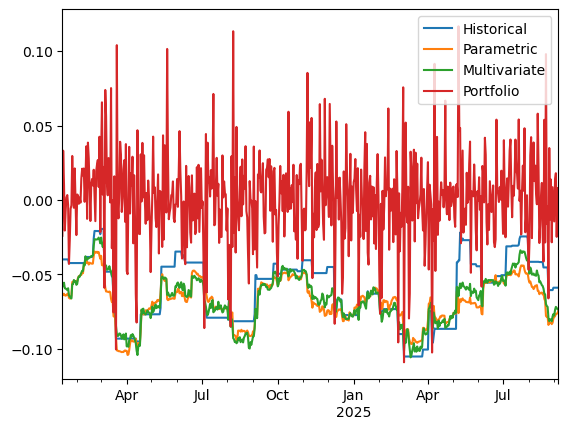

In [149]:
var_data.plot()
plt.show()

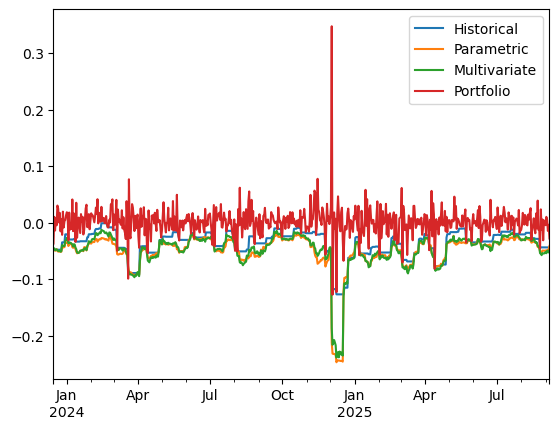

In [150]:
current_var_data.plot()
plt.show()


In [151]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.038206,0.01495,0.01495
Kupiec Stat,1.912358,21.237664,21.237664
P-value,0.166702,0.000004,0.000004


In [152]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.066456,0.011076,0.012658
Kupiec Stat,3.280246,29.09298,26.136278
P-value,0.070118,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [155]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.81183723, 0.09448844, 0.03689406, 0.03141379, 0.02536648])

In [156]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT      0.018701
ADAUSDT       0.016707
ALGOUSDT      0.020397
APTUSDT       0.017418
ARBUSDT       0.026222
ATOMUSDT      0.016057
AVAXUSDT      0.018695
BCHUSDT       0.009488
BNBUSDT       0.007911
BONKUSDT      0.023350
BTCUSDT       0.006405
CFXUSDT       0.022844
CRVUSDT       0.020439
DOGEUSDT      0.020396
DOTUSDT       0.017816
ENSUSDT       0.020147
ETCUSDT       0.017418
ETHUSDT       0.016344
FDUSDUSDT     0.000085
FETUSDT       0.018780
FILUSDT       0.018042
FLOKIUSDT     0.025154
GRTUSDT       0.019600
HBARUSDT      0.019864
ICPUSDT       0.017621
IMXUSDT       0.024098
INJUSDT       0.023808
LDOUSDT       0.023895
LINKUSDT      0.020738
LTCUSDT       0.013219
MKRUSDT       0.015176
NEARUSDT      0.020976
NEXOUSDT      0.006931
OMUSDT        0.020704
OPUSDT        0.024422
PAXGUSDT      0.000082
PENDLEUSDT    0.020328
PEPEUSDT      0.022404
QNTUSDT       0.013443
RAYUSDT       0.021313
SEIUSDT       0.022410
SHIBUSDT      0.016215
SOLUSDT       0.016741
STXUSDT    

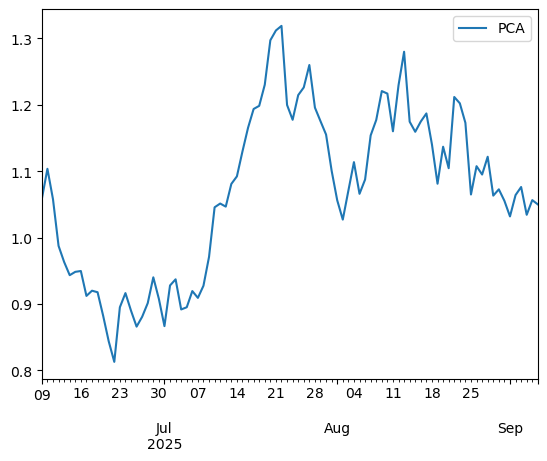

In [157]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

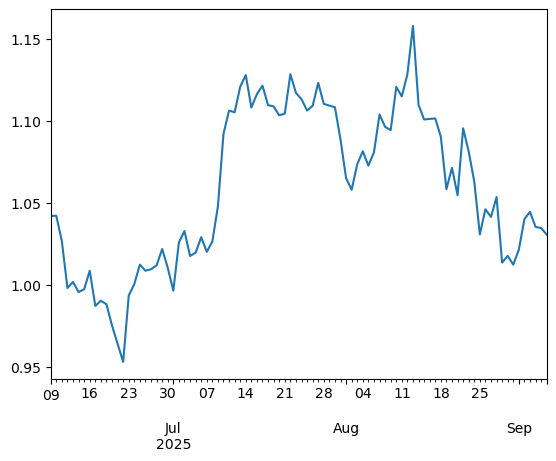

In [158]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [159]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
THETAUSDT    0.100229
SHIBUSDT     0.107045
DOTUSDT      0.107577
GRTUSDT      0.109651
NEARUSDT     0.111515
FILUSDT      0.113961
ICPUSDT      0.123618
ATOMUSDT     0.124873
VETUSDT      0.126207
STXUSDT      0.135687
AVAXUSDT     0.139266
PEPEUSDT     0.157541
DOGEUSDT     0.161536
ENSUSDT      0.162635
WBETHUSDT    0.166282
ETHUSDT      0.166512
FETUSDT      0.176663
ADAUSDT      0.180624
IMXUSDT      0.185375
dtype: float64

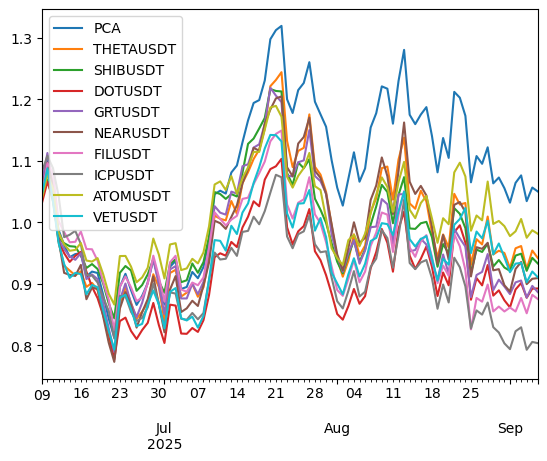

In [160]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

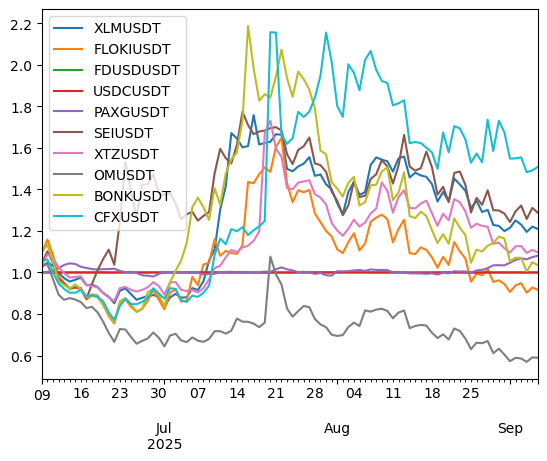

In [161]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [163]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.73655839, 0.18319692, 0.03614746, 0.02738643, 0.0167108 ])

In [164]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.046779
BTCUSDT     0.059533
OMUSDT      0.268912
ETHUSDT     0.160346
SOLUSDT     0.164005
BNBUSDT     0.078695
PEPEUSDT    0.221286
PAXGUSDT    0.000446
Name: PC1, dtype: float64

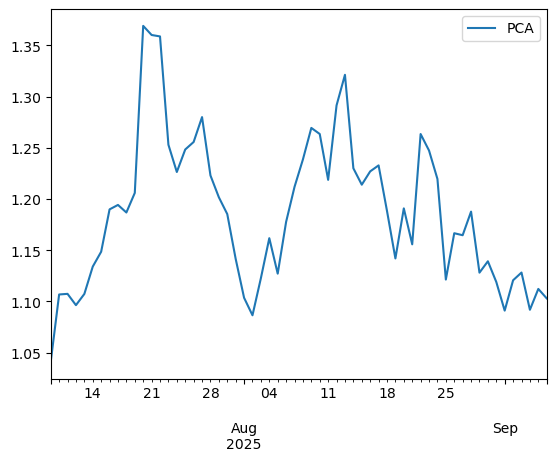

In [165]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

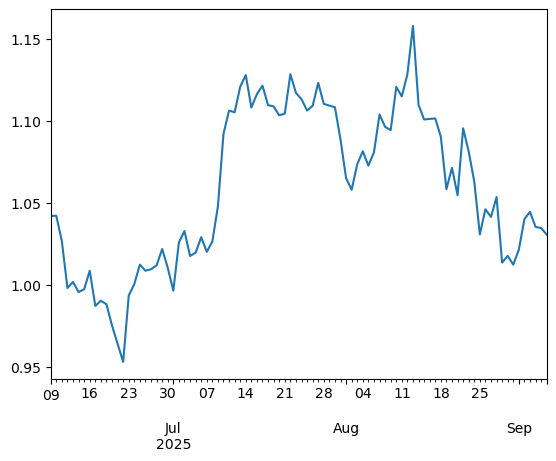

In [166]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [167]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.187969
PEPEUSDT    0.196453
SOLUSDT     0.210441
BNBUSDT     0.233484
BTCUSDT     0.258292
TRXUSDT     0.298399
OMUSDT      0.350924
PAXGUSDT    0.353051
dtype: float64

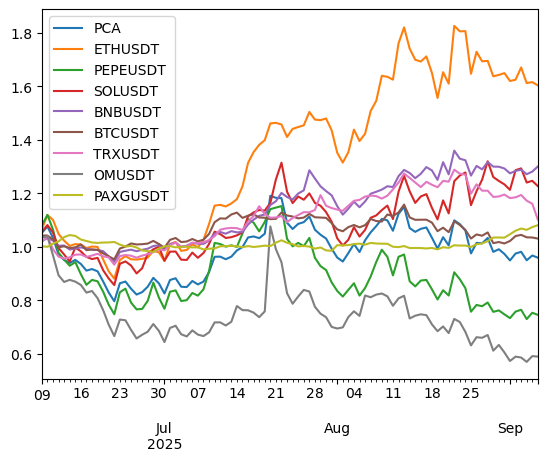

In [168]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [170]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.923579
SOLUSDT     1.298946
ETHUSDT     1.109409
OMUSDT      1.011288
BTCUSDT     1.000000
BNBUSDT     0.671420
TRXUSDT     0.340272
PAXGUSDT    0.030212
Name: BTCUSDT, dtype: float64

In [171]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT     1.979301
PEPEUSDT    1.940772
OMUSDT      1.821678
ETHUSDT     1.792033
BTCUSDT     1.000000
BNBUSDT     0.982368
TRXUSDT     0.722409
PAXGUSDT    0.157900
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [173]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [174]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.272618
PEPEUSDT,0.268685
PAXGUSDT,0.248842
ETHUSDT,0.230547
OMUSDT,0.221769
SOLUSDT,0.153469
TRXUSDT,0.016025
BNBUSDT,-0.015334


### Regression to PCA

In [176]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5152700555667238

In [177]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

ETHUSDT     1.003051
PCA         1.000000
BNBUSDT     0.836684
BTCUSDT     0.798841
SOLUSDT     0.657855
PEPEUSDT    0.341874
TRXUSDT     0.305029
OMUSDT      0.151691
PAXGUSDT    0.087169
dtype: float64

In [178]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PAXGUSDT    3.223277
BTCUSDT     1.950210
BNBUSDT     1.500749
TRXUSDT     1.330107
PCA         1.000000
OMUSDT      0.912599
ETHUSDT     0.877283
SOLUSDT     0.838775
PEPEUSDT    0.830441
dtype: float64

### Correlation Matrix

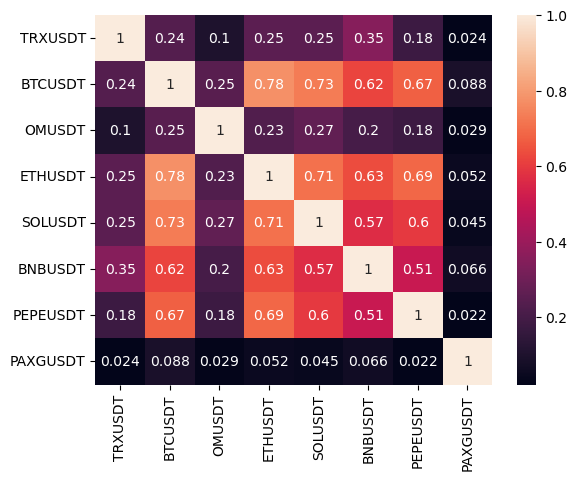

In [180]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

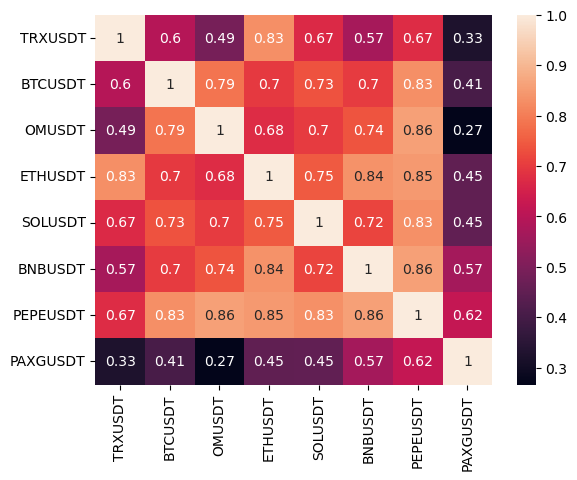

In [181]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [182]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [183]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

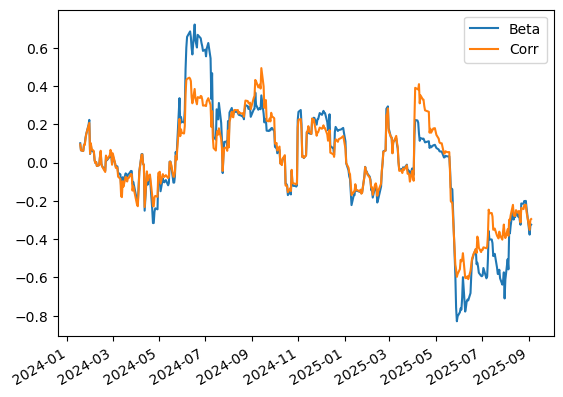

In [184]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [186]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [187]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [188]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2025-01-29,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.415812,0.000000,0.000000
2025-02-28,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-30,0.136001,0.0,0.0,0.0,0.0,0.000115,0.0,0.000401,0.000743,0.000000,...,0.0,0.0,0.0,0.0,0.000462,0.0,0.000091,0.000000,0.000000,0.000407
2025-04-29,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.029508,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-29,0.223797,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.267109
2025-06-28,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.679576,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-28,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.312739,0.045122,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.032462,0.000000,0.031893,0.000000
2025-08-27,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-09-06,0.134894,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.035999


In [189]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

LINKUSDT    0.758522
AAVEUSDT    0.134894
TRXUSDT     0.106584
XTZUSDT     0.000000
SOLUSDT     0.000000
NEARUSDT    0.000000
Name: 2025-08-27 00:00:00, dtype: float64

In [190]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
